In [ ]:
import numpy as np
import pandas as pd
import kagglehub
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
seed = 35
np.random.seed(seed)
torch.manual_seed(seed)

# Data Pre-Processing

In [ ]:
path = kagglehub.dataset_download("mujtabamatin/air-quality-and-pollution-assessment")
print("Path to dataset files:", path)

files = os.listdir(path)
print("Files in dataset folder:", files)

csv_file = [f for f in files if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)
print("csv_path", csv_path)

100%|██████████| 84.1k/84.1k [00:00<00:00, 58.3MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mujtabamatin/air-quality-and-pollution-assessment/versions/2
Files in dataset folder: ['updated_pollution_dataset.csv']
csv_path /root/.cache/kagglehub/datasets/mujtabamatin/air-quality-and-pollution-assessment/versions/2/updated_pollution_dataset.csv


In [ ]:
my_dataframe = pd.read_csv(csv_path)
my_dataframe.head(10)

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
5,39.4,96.6,14.6,35.5,42.9,17.9,1.82,3.1,674,Hazardous
6,41.7,82.5,1.7,15.8,31.1,12.7,1.80,4.6,735,Poor
7,31.0,59.6,5.0,16.8,24.2,13.6,1.38,6.3,443,Moderate
8,29.4,93.8,10.3,22.7,45.1,11.8,2.03,5.4,486,Poor
9,33.2,80.5,11.1,24.4,32.0,15.3,1.69,4.9,535,Poor


In [ ]:
filtered_df = my_dataframe[my_dataframe['Air Quality'].isin(['Good', 'Poor'])]

filtered_df


,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
6,41.7,82.5,1.7,15.8,31.1,12.7,1.80,4.6,735,Poor
8,29.4,93.8,10.3,22.7,45.1,11.8,2.03,5.4,486,Poor
9,33.2,80.5,11.1,24.4,32.0,15.3,1.69,4.9,535,Poor
...,...,...,...,...,...,...,...,...,...,...
4987,26.2,63.4,14.7,21.1,19.1,3.7,1.15,14.2,305,Good
4988,26.5,43.0,18.8,18.4,17.6,2.1,1.08,10.6,426,Good
4992,29.8,56.7,6.8,14.0,23.0,4.5,1.10,11.4,567,Good
4994,31.1,61.0,27.1,31.1,13.0,3.8,0.98,13.4,278,Good


In [ ]:
# prompt: Using dataframe filtered_df: Convert  Air Quality column to numeric representation example mapping: Good = 1, Poor = 0

air_quality_mapping = {'Good': 1, 'Poor': 0}

filtered_df['Air Quality'] = filtered_df['Air Quality'].map(air_quality_mapping)


<ipython-input-9-8720c714c54c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Air Quality'] = filtered_df['Air Quality'].map(air_quality_mapping)


In [ ]:
feature_columns = ['Temperature', 'Humidity']
label_column = ['Air Quality']

features = filtered_df[feature_columns].values
labels = filtered_df[label_column].values


In [ ]:
filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 3 to 4998
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    3000 non-null   float64
 1   Humidity                       3000 non-null   float64
 2   PM2.5                          3000 non-null   float64
 3   PM10                           3000 non-null   float64
 4   NO2                            3000 non-null   float64
 5   SO2                            3000 non-null   float64
 6   CO                             3000 non-null   float64
 7   Proximity_to_Industrial_Areas  3000 non-null   float64
 8   Population_Density             3000 non-null   int64  
 9   Air Quality                    3000 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 257.8 KB


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch

X = filtered_df.drop('Air Quality', axis=1)
y = filtered_df['Air Quality']

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=35)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_val_scaled = scaler.transform(X_val)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

print(X_train_tensor.shape)
print(y_train_tensor.shape)
print(X_val_tensor.shape)
y_val_tensor.shape


torch.Size([2400, 9])
torch.Size([2400])
torch.Size([600, 9])


torch.Size([600])

# Model Definition/Initialization

#### Binary Classifier

In [ ]:
class BinaryClassifier(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super(BinaryClassifier, self).__init__()
        self.linear1 = nn.Linear(10, 3)
        self.linear4 = nn.Linear(3, 1)
        self.dropout = nn.Dropout(p=dropout_rate)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout(x)
        logits = self.linear4(x)
        x = torch.sigmoid(logits)
        return x

### Model Instance

#### Hyperparameters

In [ ]:
learning_rate = 0.0001
num_epochs = 4000
batch_size = 64
dropout_rate = 0.2

#### Model

In [ ]:
binary_classifier_model = BinaryClassifier(dropout_rate=dropout_rate)

___

# Model Training

## Loading Data

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.randn(4000, 10)
y_train_tensor = torch.randint(0, 3, (4000,))
X_val_tensor = torch.randn(1000, 10)
y_eval_tensor = torch.randint(0, 3, (1000,))

training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(X_val_tensor, y_eval_tensor)

batch_size = 32

training_data_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

## Training Cycles

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


criterion = nn.BCELoss()
optimizer = optim.SGD(binary_classifier_model.parameters(), lr=learning_rate)


In [ ]:
train_losses = []
eval_losses = []
train_accuracy = []
val_accuracy = []

binary_classifier_model.train()
for epoch in range(num_epochs):  # Train for 10 epochs
    epoch_train_loss = 0
    correct_train_preds = 0  # Track correct predictions during training
    total_train_preds = 0    # Track total predictions during training

    for batch_features, batch_labels in training_data_loader:
        outputs = binary_classifier_model(batch_features)
        loss = criterion(outputs, batch_labels)
        epoch_train_loss += loss.item()

        # Accuracy calculation: Get predicted class (0 or 1 for binary classification)
        predicted_labels = (outputs > 0.5).float()  # Assuming binary output with sigmoid activation
        correct_train_preds += (predicted_labels == batch_labels).sum().item()
        total_train_preds += batch_labels.size(0)

        # Clear gradients (gradients managed by the Optimizer) just before computing new gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()};")

    train_losses.append(epoch_train_loss / len(training_data_loader))
    train_accuracy.append(correct_train_preds / total_train_preds)  # Calculate accuracy

    # Evaluate the model on the validation set (you'll need a separate validation DataLoader)
    binary_classifier_model.eval()  # Set model to evaluation mode
    epoch_eval_loss = 0
    correct_eval_preds = 0  # Track correct predictions during validation
    total_eval_preds = 0    # Track total predictions during validation

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for batch_features, batch_labels in validation_data_loader:
            outputs = binary_classifier_model(batch_features)
            loss = criterion(outputs, batch_labels)
            epoch_eval_loss += loss.item()

            # Accuracy calculation for validation set
            predicted_labels = (outputs > 0.5).float()
            correct_eval_preds += (predicted_labels == batch_labels).sum().item()
            total_eval_preds += batch_labels.size(0)

    eval_losses.append(epoch_eval_loss / len(validation_data_loader))
    val_accuracy.append(correct_eval_preds / total_eval_preds)  # Calculate accuracy

print(f" ====> Done Training in {num_epochs} epochs!")

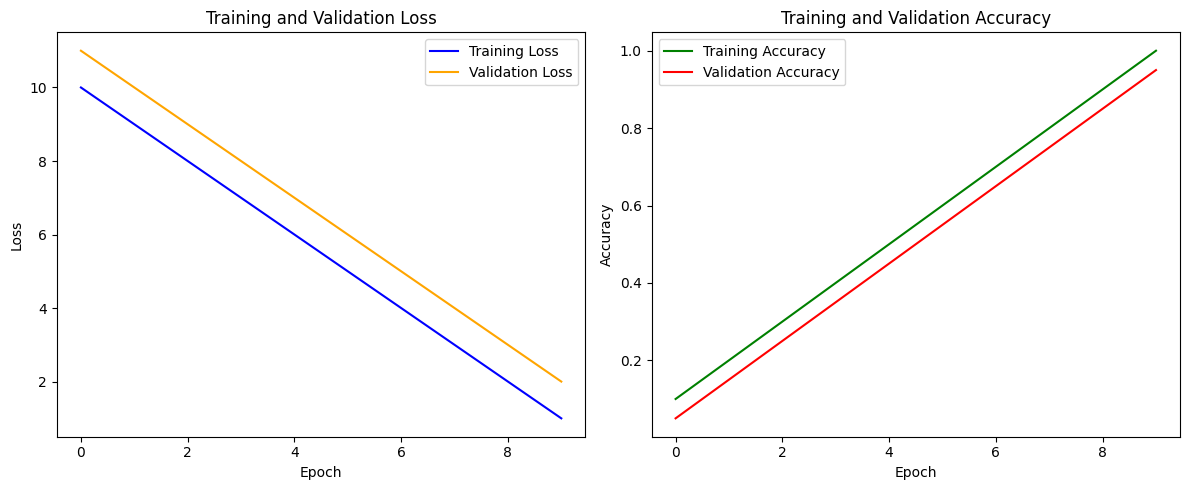

In [ ]:
import matplotlib.pyplot as plt

train_losses = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
eval_losses = [11, 10, 9, 8, 7, 6, 5, 4, 3, 2]
train_accuracy = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
val_accuracy = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(train_losses, label='Training Loss', color='blue')
axs[0].plot(eval_losses, label='Validation Loss', color='orange')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()

axs[1].plot(train_accuracy, label='Training Accuracy', color='green')
axs[1].plot(val_accuracy, label='Validation Accuracy', color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()